# Storm Data Prediciton
## Group 1: Dhairya Dodia, Duncan Conley, Jameson Thomas
----------------------------------------------------------

### Step 0: Import libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

### Step 1: Load & Prep Data

NaNs in X after imputation: False
NaNs in X_train: False
NaNs in X_test: False
Accuracy: 0.8488107172149822
Classification Report:
               precision    recall  f1-score   support

        high       0.47      0.42      0.44       769
         low       0.92      0.93      0.92      9038
      medium       0.51      0.51      0.51      1166

    accuracy                           0.85     10973
   macro avg       0.63      0.62      0.63     10973
weighted avg       0.85      0.85      0.85     10973



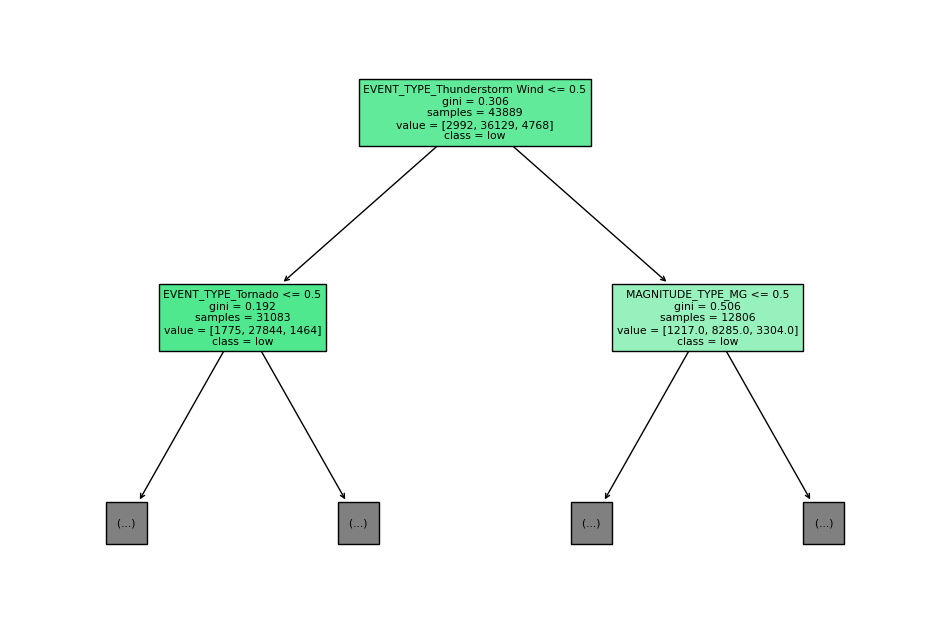

Columns used in the model: ['MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'LAT', 'LON', 'ELAPSED_TIME_MIN', 'EVENT_TYPE_Avalanche', 'EVENT_TYPE_Blizzard', 'EVENT_TYPE_Coastal Flood', 'EVENT_TYPE_Cold/Wind Chill', 'EVENT_TYPE_Debris Flow', 'EVENT_TYPE_Dense Fog', 'EVENT_TYPE_Drought', 'EVENT_TYPE_Dust Devil', 'EVENT_TYPE_Dust Storm', 'EVENT_TYPE_Excessive Heat', 'EVENT_TYPE_Extreme Cold/Wind Chill', 'EVENT_TYPE_Flash Flood', 'EVENT_TYPE_Flood', 'EVENT_TYPE_Freezing Fog', 'EVENT_TYPE_Frost/Freeze', 'EVENT_TYPE_Funnel Cloud', 'EVENT_TYPE_Hail', 'EVENT_TYPE_Heat', 'EVENT_TYPE_Heavy Rain', 'EVENT_TYPE_Heavy Snow', 'EVENT_TYPE_High Surf', 'EVENT_TYPE_High Wind', 'EVENT_TYPE_Hurricane', 'EVENT_TYPE_Ice Storm', 'EVENT_TYPE_Lake-Effect Snow', 'EVENT_TYPE_Lightning', 'EVENT_TYPE_Marine Dense Fog', 'EVENT_TYPE_Marine Hail', 'EVENT_TYPE_Marine High Wind', 'EVENT_TYPE_Marine Hurricane/Typhoon', 'EVENT_TYPE_Marine Strong Wind', 'EVENT_TYPE_Marine Thunderstorm Wind', 'EVENT_TYPE_Marine Tropical Depression'

In [ ]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz"  # data

# Read the CSV file
df = pd.read_csv(file_path)

### --- FEATURE ENGINEER COLUMNS --- ###

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_latitudes(row):
    if pd.notna(row['BEGIN_LAT']) and pd.notna(row['END_LAT']):
        return (row['BEGIN_LAT'] + row['END_LAT']) / 2  # LAT = Average (both present)
    elif pd.notna(row['BEGIN_LAT']):
        return row['BEGIN_LAT']  # LAT = BEGIN_LAT (END_LAT missing)
    elif pd.notna(row['END_LAT']):
        return row['END_LAT']  # LAT = END_LAT (BEGIN_LAT missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_LON and END_LON into a single LON column
def combine_longitudes(row):
    if pd.notna(row['BEGIN_LON']) and pd.notna(row['END_LON']):
        return (row['BEGIN_LON'] + row['END_LON']) / 2  # LON = Average (both present)
    elif pd.notna(row['BEGIN_LON']):
        return row['BEGIN_LON']  # LON = BEGIN_LON (END_LON missing)
    elif pd.notna(row['END_LON']):
        return row['END_LON']  # LON = END_LON (BEGIN_LON missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_DATE_TIME and END_DATE_TIME into a single ELAPSED_TIME_MIN column
def calculate_elapsed_minutes(row):
    # Convert the strings to datetime objects using the correct format
    begin_time = pd.to_datetime(row['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    end_time = pd.to_datetime(row['END_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    
    # If either conversion fails, return NaN
    if pd.isna(begin_time) or pd.isna(end_time):
        return np.nan

    # Compute the elapsed time in minutes and return as an integer
    elapsed = end_time - begin_time
    return int(elapsed.total_seconds() // 60)

def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions)
    try:
        return float(value)
    except ValueError:
        return 0

# Drop all rows in which there is no DAMAGE_PROPERTY
df = df[pd.notna(df['DAMAGE_PROPERTY'])]

# Convert damage values to numeric
df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

# Create new columns from longitudes, latitudes, and elapsed time
df['LAT'] = df.apply(combine_latitudes, axis=1)
df['LON'] = df.apply(combine_longitudes, axis=1)
df['ELAPSED_TIME_MIN'] = df.apply(calculate_elapsed_minutes, axis=1)

# Drop unnecessary columns
df = df.drop(columns=[
    'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
    'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
    'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
    'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
    'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
    'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LOCATION', 'END_LOCATION',
    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 'YEAR', 'CATEGORY'
])

# Create the damage category using pd.cut; include the lowest value in the first bin.
bins = [0, 1000, 10000, np.inf]
labels = ['low', 'medium', 'high']
df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)

# --- ENCODE CATEGORICAL VARIABLES --- #
# List of categorical columns that you want to include as features
categorical_columns = ['EVENT_TYPE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE']

# Use get_dummies to convert categorical columns to dummy/indicator variables.
encoded_cats = pd.get_dummies(df[categorical_columns], drop_first=True)

# --- PREPARE FEATURE MATRIX --- #
# Select the numeric columns and drop any that are not desired as features.
numeric_columns = df.select_dtypes(include=[np.number]).columns
X_numeric = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])

# Combine numeric features with the encoded categorical features.
X_full = pd.concat([X_numeric, encoded_cats], axis=1)

# Impute missing values in the feature matrix
imputer = SimpleImputer(strategy='median')
X_full = imputer.fit_transform(X_full)

# The target remains your damage category.
y = df['DAMAGE_CATEGORY'].values

# Check for NaN values in the feature matrix
print("NaNs in X after imputation:", np.isnan(X_full).any())

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Confirm that there are no NaN values in the splits.
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())

# Train the Decision Tree Classifier.
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set and evaluate the model.
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree.
plt.figure(figsize=(12, 8))

# For plotting, combine feature names for numeric and dummy variables.
numeric_feature_names = X_numeric.columns.tolist()
categorical_feature_names = encoded_cats.columns.tolist()
feature_names = numeric_feature_names + categorical_feature_names

plot_tree(clf, feature_names=feature_names, class_names=clf.classes_, filled=True, max_depth=1)
plt.show()

print("Columns used in the model:", feature_names)




# Feature Engineering


# Clustering

# Most association with different features